# Investigating Fandango Movie Ratings

## Is Fandango still inflating ratings ?

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis in [this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) - totally worth reading.

In 2015 Fandango used to display a 5 star-rating system on their web site, where the minimum score was 0 stars and the maximum was represented by 5 stars.

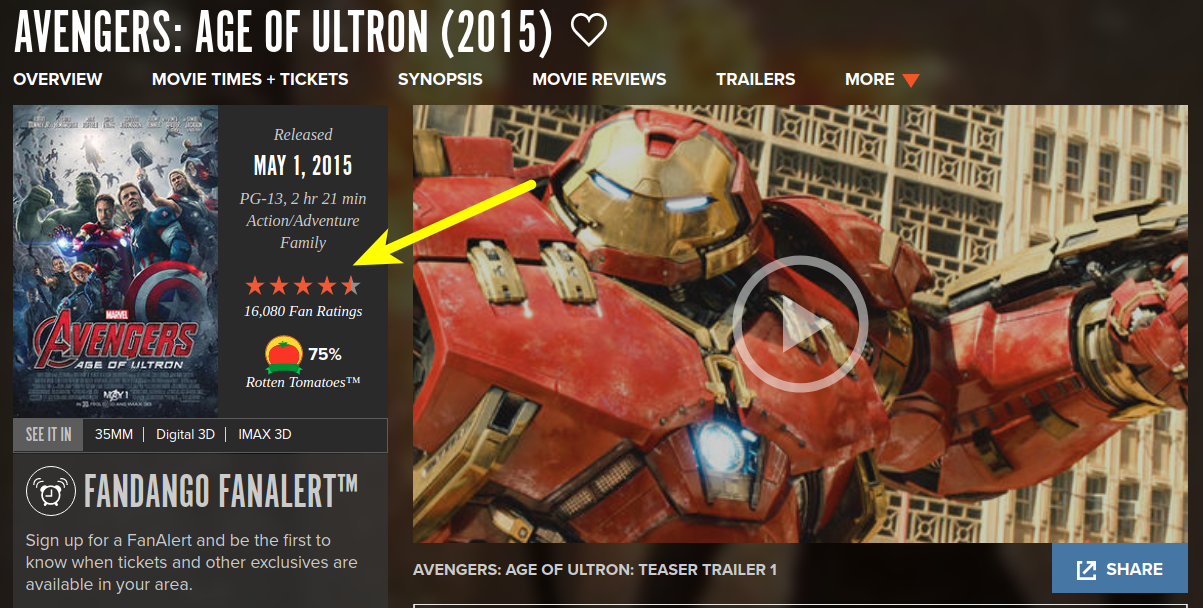

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

* The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
* In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
* For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

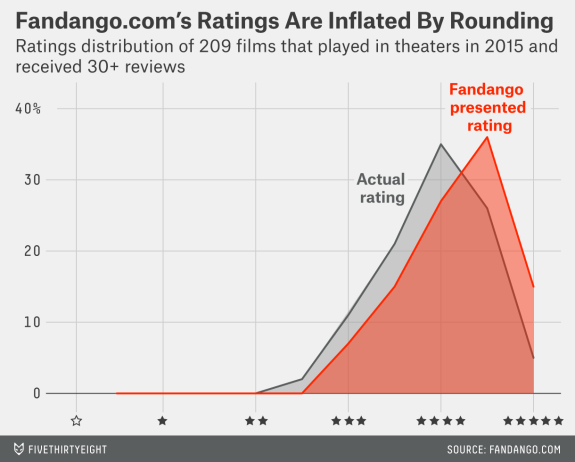


In the graph above, for example, we can see that both the distributions are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high.

In fact there are no movies that scored less than 2 stars.  The distribution of displayed ratings is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

On these premises we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's article.

We're going to use Walt Hickey dataset which can be found [here](https://github.com/fivethirtyeight/data/tree/master/fandango)
and a second dataset created after Hickey's article. The second dataset is publicly available [on Github](https://github.com/mircealex/Movie_ratings_2016_17) and contains movies from 2016/2017 season.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import random
import time
import wikipedia
%matplotlib inline

# read two datasets

before = pd.read_csv("fandango_score_comparison.csv")
after = pd.read_csv("movie_ratings_16_17.csv")

before.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [2]:
after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


The **fandango_score_comparison** contains every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, a IMDB score, and at least 30 fan reviews on Fandango. All the scores are both in absolute values and normalized to a 0-5 scale.

The **movie_ratings_16_17** contains movie rating for the 214 most popular movies released in 2016 and 2017.
We will now isolate in separate variables the columns that offer information about Fandango's ratings in separate variables

For the dataset previous to Hickey's article we'll select the following columns: `'FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference'`.
And for the other dataset the columns: `'movie', 'year', 'fandango'`

In [3]:
# isolating the columns into variables

# 1st dataset
fandango_before = before[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()

# 2nd dataset
fandango_after = after[['movie', 'year', 'fandango']].copy()

# checking
fandango_before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [4]:
fandango_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


At this point we remember that our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. By doing this, we first have to understand if both the datasets are highly representative of the entire population and by clarifing so if they are usefull for our purposes. An high level of representativeness is given by sampling data in a random way so that every entry or, in this case, movie has the same possibility to appear into the dataset; if a large sample of data is biased by some reason or particular filtering strategy, we could expect a large **sampling error** and, in the end, wrong conclusions.

If we read the documentation of the first dataset that you can read [here](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md), we see that Walt Hickey criteria of choose was:
* Each movie has to have at least 30 users' review on Fandango
* Every movie is from 2015

These way of sampling doesn't seem really random. First he considered only movies that had at least 30 reviews (narrowing down the possibility for other movies to be picked) and by filtering the year to just the 2015, we really cannot tell if either the Fandango rating was some how biased or if 2015 was just a very good year for cinema with great movies being published.

Also the second dataset (which documentation can be found [here](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/README.md)) is subject to the same sampling methods.
In details:
* Each movie must have a significant number of votes 
* Temporal sampling approach by selecting movies only from 2016 and 2017

In conclusion the data used in both datasets are not representative of the total population that we need for our analysis.
The two authors moved by different goals decided to filter data in a way that can't be either representative or useful for us.

At this point we have two alternatives: either we collect new data, either we change the goal of our analysis by placing some limitations to it.
For the fact that it would be quasi-impossible to collect a new sample previous to Hickey's analysis at this moment in time (2021), slightly change the goal seems to be the right path to take.

## Changing the path of our analysis

We'll limit our analysis to check if the Fandango's ratings changed between 2015 and 2016.
By scraping some data from wikipedia, we'll check the budget of each movie, calculate the mean and see if  during those two years there are major differences.

With the new goal, we now have two populations that we want to describe and compare with each other:

* All Fandango's ratings for popular movies released in 2015.
* All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has **30 fan ratings or more** on Fandango's website.

First thing first, we'll check if there is any movie with less than 30 fan ratings in the first dataset. Supposedly there's shouldn't be cause the author of the article established some specific ways for filtering the data, but we are gonna check however.

In [5]:
sum(fandango_before['Fandango_votes'] < 30)

0

As we were expecting, no movies under 30 user's review.

For the second dataset we have an issue: there's no way to see the number of review for each movie so we have to find a way to check the condition whether it is true or false.
We'll extract a sample of 10 elements and we'll check manually the number of reviews on **Rotten tomatoes** (nowadays Fandango is powered by Rotten tomatoes for users' review). If the percentage of movies with a number of user ratings greater than 30 is bigger or equal than 80/85%, we can say that the second dataset is usefull for our purposes.

In [6]:
fandango_after.sample(10, random_state=42)

,movie,year,fandango
9,Amateur Night,2016,3.5
197,The Take (Bastille Day),2016,4.0
66,"Hail, Caesar!",2016,2.5
191,The Perfect Match,2016,4.0
117,Morgan,2016,3.5
111,Miracles from Heaven,2016,4.5
15,Bad Moms,2016,4.5
86,Julieta,2016,3.5
75,Ice Age: Collision Course,2016,4.0
144,Sing Street,2016,4.5


**42** as a pseudo random number is just a reference from *Hitchhikers guide to galaxy book*.
We're just using a random seed for making our sample generation predictable.

| Movie                     | Nr_of_ratings |
|---------------------------|---------------|
| Amateur Night             | 250+          |
| The take (Bastille day)   | 2500+         |
| Hail, Caesar!             | 25000+        |
| The perfect match         | 250+          |
| Morgan                    | 5000+         |
| Miracles from heaven      | 10000+        |
| Bad moms                  | 25000+        |
| Julieta                   | 2500+         |
| Ice Age: Collision Course | 25000+        |
| Sing street               | 10000+        |

It appears that all the movie have a number of ratings that by far overcome the threshol we established.
At this point we can be sure that also the second dataframe is fully representative of the total population we want to analyze.

That said we want to check if all the movies in the first dataset were released in 2015 (cause that is the year we're interested in).

In [7]:
# checking FILM series

fandango_before.FILM

0                 Avengers: Age of Ultron (2015)
1                              Cinderella (2015)
2                                 Ant-Man (2015)
3                         Do You Believe? (2015)
4                  Hot Tub Time Machine 2 (2015)
                         ...                    
141                            Mr. Holmes (2015)
142                                   '71 (2015)
143                   Two Days, One Night (2014)
144    Gett: The Trial of Viviane Amsalem (2015)
145           Kumiko, The Treasure Hunter (2015)
Name: FILM, Length: 146, dtype: object

We can see that, for the way is the title formatted, we can extract the year and create a new column for the dataframe.

In [8]:
# extracting the year and creating new column

fandango_before['YEAR'] = fandango_before.FILM.str[-5:-1]

# check value counts

fandango_before.YEAR.value_counts()

2015    129
2014     17
Name: YEAR, dtype: int64

There are 17 movies which were published in 2014. 
We're gonna isolate those rows.

In [9]:
fandango_2015 = fandango_before[fandango_before['YEAR'] == '2015'].copy()

# checking
fandango_2015.YEAR.value_counts()

2015    129
Name: YEAR, dtype: int64

Let's now check the values for the second dataset.

In [10]:
fandango_after.year.value_counts()

2016    191
2017     23
Name: year, dtype: int64

In the second dataset we see 23 movies from 2017.
We'll isolate them to create a dataframe with only movies from 2016.

In [11]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()

# checking results

fandango_2016.year.value_counts()

2016    191
Name: year, dtype: int64

In [12]:
# renaming column

fandango_2015.rename(columns={'Fandango_Ratingvalue': 'Fandango_Rating', 'YEAR': 'year'}, inplace=True)

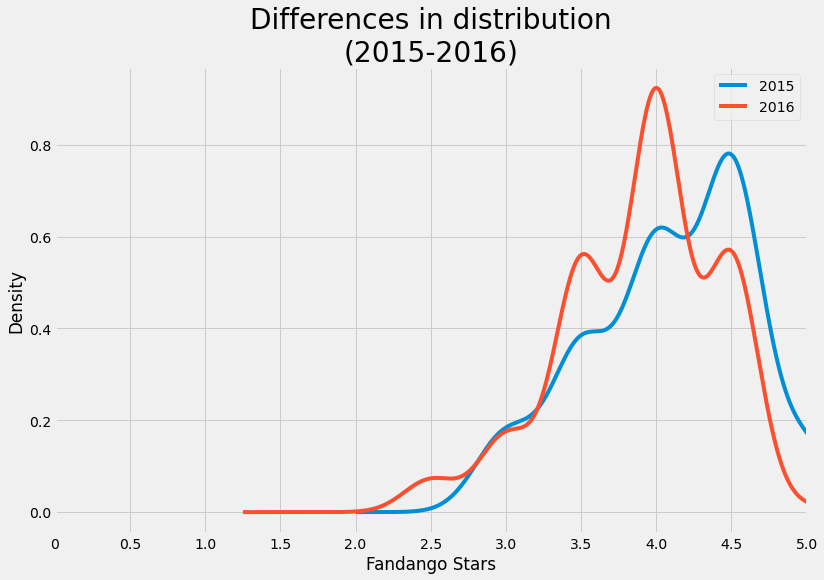

In [13]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
fandango_2015.Fandango_Stars.plot.kde(label='2015', legend=True)
fandango_2016.fandango.plot.kde(label='2016', legend=True)
plt.xlim(0,5)
plt.xticks(ticks= [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
           labels=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

plt.xlabel(xlabel='Fandango Stars')
plt.title("Differences in distribution\n(2015-2016)", fontdict={'fontsize': 28})
plt.show()

From this graph we can see that both 2015 and 2016 distributions are highly left skewed, with the majority of the movies obtaining very high scores and no movie with a score lower than 2 stars.
If we analyze deeply the two distributions we see that the 2016 one is slightly less skewed than the previous. The concentration of the distribution for the year **2016** is more dense for the 4 stars score while in **2015** it was more oriented to the 4.5/5 stars.

This could tell us that probably, after the article of Walt Hickey, **Fandango** decided to change somehow the mechanism of scoring and to assign scores slighlty more distributed.

We will now examine the frequency table of the two distributions, for more granular data.

In [14]:
print("2015 score distribution:")
round(fandango_2015.Fandango_Stars.value_counts(normalize=True) * 100, 2).sort_index(ascending=False)

2015 score distribution:


5.0     6.98
4.5    37.98
4.0    28.68
3.5    17.83
3.0     8.53
Name: Fandango_Stars, dtype: float64

In [15]:
print("2016 score distribution:")
round(fandango_2016.fandango.value_counts(normalize=True) * 100, 2).sort_index(ascending=False)

2016 score distribution:


5.0     0.52
4.5    24.61
4.0    40.31
3.5    24.08
3.0     7.33
2.5     3.14
Name: fandango, dtype: float64

The frequency tables show what we previously taught from the graph.
In **2015** there were **6.98%** of the scores which were 5 stars, while in **2016** that percentage is reduced to **0.52%**.

For the fact that is unrealistic that in one year almost **7%** of the titles were top scorer, is legit to think that **Fandango** probably improved its way of rating movies in a more serious and strict way; by saying this, probably Walt Hickey's article hit the point and showed some critical issues of the way of approaching the reviews by the website.

## Calculating summary statistics.

We'll now calculate some summary statistics for the rating score across the two year.
Specifically we'll calculate **mean**, **median** and **mode** and then compare the values to see how is the direction of the differences.

In [16]:
mean_2015 = fandango_2015.Fandango_Stars.mean()
mean_2016 = fandango_2016.fandango.mean()
median_2015 = fandango_2015.Fandango_Stars.median()
median_2016 = fandango_2016.fandango.median()
mode_2015 = fandango_2015.Fandango_Stars.mode()[0]
mode_2016 = fandango_2016.fandango.mode()[0]

summary_statistics = pd.DataFrame()

summary_statistics['2015'] = [mean_2015, median_2015, mode_2015]
summary_statistics['2016'] = [mean_2016, median_2016, mode_2016]

summary_statistics.index = ['mean', 'median', 'mode']

summary_statistics

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


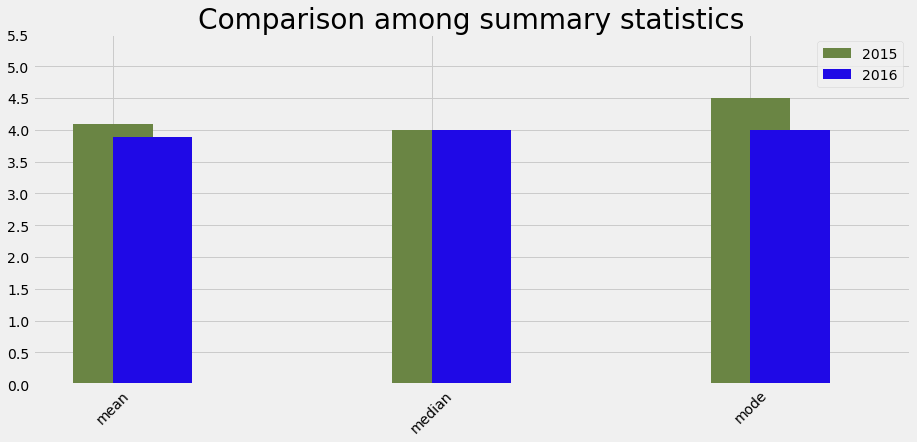

In [17]:
summary_statistics['2015'].plot.bar(color = '#6a8544', align = 'center', label = '2015', width = .25)
summary_statistics['2016'].plot.bar(color = '#1f09e6', align = 'edge', label = '2016', width = .25,
                                    rot = 45, figsize = (14,6))
plt.ylim((0,5.5))
plt.yticks([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])
plt.legend()
plt.title("Comparison among summary statistics", fontdict={'fontsize': 28})
plt.show()

The mean value is slightly less in **2016** showing **3.89** vs **4.08**.
The mode is the statistic that appears to have mostly change during the year, dropping of 0.5 points (**4.5** in 2015 against **4.0** in 2016).

Effectively **Fandango** slightly changed the way of evaluating the movies after the aforementioned article.

## Scraping further data

If we visit the *wikipedia page* of each movie, we see that among other informations, we can find the budget and the box office results for that specific movie.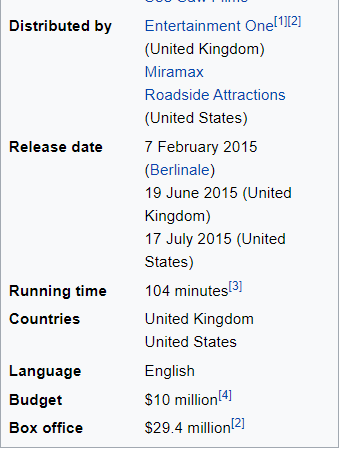

We will scrape those data from wikipedia and create two new columns for each dataframe.
For doing that we'll use **Beautiful Soup** module and create a function that will use also wikipedia module.

In [19]:
def scrape_wiki(df):
    
    movie_title = df['movie']
    year = df['year']
    
    budget = None
    box_office = None
    distribution = None
    
    try:
        page = wikipedia.WikipediaPage(title=f"{movie_title}").html()
        
        soup = BeautifulSoup(page, 'html.parser')
        
        len_tag = len(soup.find_all('th', class_="infobox-label"))
        
        for i in range(len_tag):
            tag_name = soup.find_all('th', class_="infobox-label")[i]
            if tag_name.text == 'Budget':
                budget_data = soup.find_all("td", class_="infobox-data")[i].text
                budget = budget_data
            elif tag_name.text == 'Box office':
                box_off_data = soup.find_all("td", class_="infobox-data")[i].text
                box_office = box_off_data
            elif tag_name.text == 'Distributed by':
                dist_data = soup.find_all("td", class_='infobox-data')[i].text
                distribution = dist_data
                
    except wikipedia.exceptions.DisambiguationError:
        
        try:
            page = wikipedia.WikipediaPage(title=f"{movie_title} (film)").html()
                
            soup = BeautifulSoup(page, 'html.parser')
                
            len_tag = len(soup.find_all('th', class_="infobox-label"))
                
            for i in range(len_tag):
                tag_name = soup.find_all('th', class_="infobox-label")[i]
                if tag_name.text == 'Budget':
                    budget_data = soup.find_all("td", class_="infobox-data")[i].text
                    budget = budget_data
                elif tag_name.text == 'Box office':
                    box_off_data = soup.find_all("td", class_="infobox-data")[i].text
                    box_office = box_off_data
                elif tag_name.text == 'Distributed by':
                    dist_data = soup.find_all("td", class_='infobox-data')[i].text
                    distribution = dist_data
                    
        except wikipedia.exceptions.DisambiguationError:
            
            page = wikipedia.WikipediaPage(title=f"{movie_title} ({year} film)").html()
                
            soup = BeautifulSoup(page, 'html.parser')
                
            len_tag = len(soup.find_all('th', class_="infobox-label"))
                
            for i in range(len_tag):
                tag_name = soup.find_all('th', class_="infobox-label")[i]
                if tag_name.text == 'Budget':
                    budget_data = soup.find_all("td", class_="infobox-data")[i].text
                    budget = budget_data
                elif tag_name.text == 'Box office':
                    box_off_data = soup.find_all("td", class_="infobox-data")[i].text
                    box_office = box_off_data
                elif tag_name.text == 'Distributed by':
                    dist_data = soup.find_all("td", class_='infobox-data')[i].text
                    distribution = dist_data
    finally:
        return budget, box_office, distribution
    
    return budget, box_office, distribution

In [ ]:
fandango_2016['movie_data'] = fandango_2016.apply(scrape_wiki, axis=1)

In [ ]:
fandango_2016.head(30)

In [ ]:
fandango_2016['movie_budget'] = fandango_2016.movie_data.str[0]
fandango_2016['box_office'] = fandango_2016.movie_data.str[1]
fandango_2016['distribution'] = fandango_2016.movie_data.str[2]

Let's now check for missing values and how our function worked

In [ ]:
print(fandango_2016.movie_budget.isnull().sum() / fandango_2016.shape[0])
print(fandango_2016.box_office.isnull().sum() / fandango_2016.shape[0])
print(fandango_2016.distribution.isnull().sum() / fandango_2016.shape[0])

This just show us the percentage of missing data but doesn't tell us much either our function worked properly. To do that we want to find all the movies where **movie_budget**, **box_office** and **distribution** are missing.

In [ ]:
fandango_2016.loc[(fandango_2016.movie_budget.isnull()) \
                  & (fandango_2016.box_office.isnull()) \
                  & (fandango_2016.distribution.isnull())]

Now that I found all the movies that have no data, I will use a modified function "scrape_wiki" to scrape those missing values

In [ ]:
def scrape_wiki_v2(df):
    
    movie_title = df['movie']
    year = df['year']
    
    budget = None
    box_office = None
    distribution = None
    
    try:
        page = wikipedia.WikipediaPage(title=f"{movie_title} (film)").html()
        
        soup = BeautifulSoup(page, 'html.parser')
        
        len_tag = len(soup.find_all('th', class_="infobox-label"))
        
        for i in range(len_tag):
            tag_name = soup.find_all('th', class_="infobox-label")[i]
            if tag_name.text == 'Budget':
                budget_data = soup.find_all("td", class_="infobox-data")[i].text
                budget = budget_data
            elif tag_name.text == 'Box office':
                box_off_data = soup.find_all("td", class_="infobox-data")[i].text
                box_office = box_off_data
            elif tag_name.text == 'Distributed by':
                dist_data = soup.find_all("td", class_='infobox-data')[i].text
                distribution = dist_data
                
    except wikipedia.exceptions.DisambiguationError:
        
        page = wikipedia.WikipediaPage(title=f"{movie_title} ({year} film)").html()
            
        soup = BeautifulSoup(page, 'html.parser')
            
        len_tag = len(soup.find_all('th', class_="infobox-label"))
            
        for i in range(len_tag):
            tag_name = soup.find_all('th', class_="infobox-label")[i]
            if tag_name.text == 'Budget':
                budget_data = soup.find_all("td", class_="infobox-data")[i].text
                budget = budget_data
            elif tag_name.text == 'Box office':
                box_off_data = soup.find_all("td", class_="infobox-data")[i].text
                box_office = box_off_data
            elif tag_name.text == 'Distributed by':
                dist_data = soup.find_all("td", class_='infobox-data')[i].text
                distribution = dist_data
                
    finally:
        return budget, box_office, distribution
    
    return budget, box_office, distribution

In [ ]:
missing_values_ind = fandango_2016.loc[(fandango_2016.movie_budget.isnull()) \
                      & (fandango_2016.box_office.isnull()) \
                      & (fandango_2016.distribution.isnull())].index

In [ ]:
# extracting portion of df
miss_fand = fandango_2016.loc[missing_values_ind]

miss_fand.head()

In [ ]:
miss_fand['movie_data'] = miss_fand.apply(scrape_wiki_v2, axis=1)

In [ ]:
miss_fand['movie_budget'] = miss_fand.movie_data.str[0]
miss_fand['box_office'] = miss_fand.movie_data.str[1]
miss_fand['distribution'] = miss_fand.movie_data.str[2]

In [ ]:
# dropping missing values index from 1st dataframe

fandango_2016.drop(index=missing_values_ind, inplace=True)

We now have to different dataframe that we'll concatenate.

In [ ]:
final_df = pd.concat([fandango_2016, miss_fand])

# reindexing

final_df.sort_index()

In [ ]:
# we now just have 5 movies which values will scrape manually

final_df[(final_df.movie_budget.isnull()) & (final_df.box_office.isnull()) & (final_df.distribution.isnull())]

In [ ]:
print("Null values percentage:")
final_df.loc[(final_df.movie_budget.isnull()) \
             & (final_df.box_office.isnull()) \
             & (final_df.distribution.isnull())].shape[0] / final_df.shape[0] * 100

In [ ]:
# saving dataframe into csv

final_df.to_csv('fandango_2016.csv')

## Proceding in the same way for the 2015 dataset

Now we don't need the title formatted like this "movie title (YEAR)"; we'll replace (YEAR) with ""

In [ ]:
fandango_2015['FILM'] = fandango_2015.FILM.str.replace("(", "").str.replace(")", "").str.replace("2015", "")

In [ ]:
# renaming FILM column into movie so to use scrape_wiki function

fandango_2015.rename(columns={'FILM': 'movie'}, inplace=True)

In [ ]:
fandango_2015['movie_data'] = fandango_2015.apply(scrape_wiki, axis=1)

In [ ]:
fandango_2015.head()

Of course we have missing values. Let's check how much...

In [ ]:
# creating columns we need
fandango_2015['movie_budget'] = fandango_2015.movie_data.str[0]
fandango_2015['box_off'] = fandango_2015.movie_data.str[1]
fandango_2015['distribution'] = fandango_2015.movie_data.str[2]

fandango_2015.head()

In [ ]:
fandango_2015.loc[(fandango_2015.movie_budget.isnull()) \
                 & (fandango_2015.box_off.isnull()) \
                 & (fandango_2015.distribution.isnull())]

In [ ]:
print("Percentage of null values:")
fandango_2015.loc[(fandango_2015.movie_budget.isnull()) \
                 & (fandango_2015.box_off.isnull()) \
                 & (fandango_2015.distribution.isnull())].shape[0] / fandango_2015.shape[0]

Wow! 37 % of data are null. We'll have to recheck using the second function we created.

In [ ]:
miss_values_ind = fandango_2015.loc[(fandango_2015.movie_budget.isnull()) \
                 & (fandango_2015.box_off.isnull()) \
                 & (fandango_2015.distribution.isnull())].index

miss_fand_2015 = fandango_2015.loc[miss_values_ind]

miss_fand_2015.head()

In [ ]:
# dropping the columns

miss_fand_2015.drop(['movie_data', 'movie_budget', 'distribution', 'box_off'], axis=1, inplace=True)

In [ ]:
# applying 2nd function

miss_fand_2015['movie_data'] = miss_fand_2015.apply(scrape_wiki_v2, axis=1)

In [ ]:
miss_fand_2015.head(30)

Ok things are getting better now. Let's proceed with our job.

In [ ]:
# dropping rows from original 2015
fandango_2015.drop(index=miss_values_ind, inplace=True)

fandango_2015.head()

In [ ]:
# concatenating two dataframes

final_2015_df = pd.concat([fandango_2015, miss_fand_2015])

final_2015_df.sort_index()

Ok...let's recalculate the percentage of missing values after all this job.

In [ ]:
print("Percentage of null values:")
final_2015_df.loc[(final_2015_df.movie_budget.isnull()) \
                 & (final_2015_df.box_off.isnull()) \
                 & (final_2015_df.distribution.isnull())].shape[0] / final_2015_df.shape[0]

Much better!!! Which are the movies we're missing?

In [ ]:
final_2015_df.loc[(final_2015_df.movie_budget.isnull()) \
                 & (final_2015_df.box_off.isnull()) \
                 & (final_2015_df.distribution.isnull())]

Just 14 movies are missing data. We'll add them manually...I guess...

In [ ]:
# creating new csv

final_2015_df.to_csv("fandango_2015.csv")